# Regression Script
## Random Forest for Remote Sensing Data

### Florian Beyer

2020-02-21

In [3]:
# Requried Packages
from osgeo import gdal, ogr, gdal_array # I/O image data
import numpy as np # math and array handling
import matplotlib.pyplot as plt # plot figures
import pandas as pd # handling large data as table sheets

from sklearn.ensemble import RandomForestRegressor
#from sklearn.ensemble import AdaBoostRegressor
#from sklearn import svm
#from sklearn.kernel_ridge import KernelRidge
#from sklearn.model_selection import GridSearchCV
#from sklearn.cross_decomposition import PLSRegression
#from sklearn.gaussian_process import GaussianProcessRegressor

from joblib import dump, load

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()



In [4]:
# data input

# define a number of trees that should be used (default = 500)
est = 500

# the remote sensing image you want to classify
img_RS = 'D:\\OwnCloud\\WetScapes\\2020_02_21_Regression_Biomass\\Daten\\stack_all_data_tif.tif'

# training and validation
#    as image in the same extand as your remote sensing image
#    no data pixels = 0 or negative
#    class pixels > 0 and as integer
field = 'D:\\OwnCloud\\WetScapes\\2020_02_21_Regression_Biomass\\Daten\\biomasse_all.shp'


# what is the attributes name of your classes in the shape file (field name of the classes)?
attribute = 'FM_in_Gram'


# save path, predicted image
prediction_map = 'D:\\OwnCloud\\WetScapes\\2020_02_21_Regression_Biomass\\Results\\prediction_map.tif'


# save path, trained model
save_model = 'D:\\OwnCloud\\WetScapes\\2020_02_21_Regression_Biomass\\Results\\RFR.joblib'


In [5]:
# Data preparation

# load image data

img_ds = gdal.Open(img_RS, gdal.GA_ReadOnly)

img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()

In [6]:
# Data preparation
# load training data from shape file

#model_dataset = gdal.Open(model_raster_fname)
shape_dataset = ogr.Open(field)
shape_layer = shape_dataset.GetLayer()
mem_drv = gdal.GetDriverByName('MEM')
mem_raster = mem_drv.Create('',img_ds.RasterXSize,img_ds.RasterYSize,1,gdal.GDT_UInt16)
mem_raster.SetProjection(img_ds.GetProjection())
mem_raster.SetGeoTransform(img_ds.GetGeoTransform())
mem_band = mem_raster.GetRasterBand(1)
mem_band.Fill(0)
mem_band.SetNoDataValue(0)

att_ = 'ATTRIBUTE='+attribute
# http://gdal.org/gdal__alg_8h.html#adfe5e5d287d6c184aab03acbfa567cb1
# http://gis.stackexchange.com/questions/31568/gdal-rasterizelayer-doesnt-burn-all-polygons-to-raster
err = gdal.RasterizeLayer(mem_raster, [1], shape_layer, None, None, [1],  [att_,"ALL_TOUCHED=TRUE"])
assert err == gdal.CE_None

roi = mem_raster.ReadAsArray()


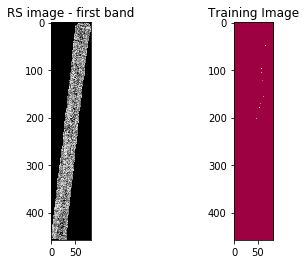

In [7]:
# Display image and Training data

plt.subplot(121)
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
plt.title('RS image - first band')

plt.subplot(122)
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('Training Image')

plt.show()


In [8]:
# Number of training pixels:
n_samples = (roi > 0).sum()
print('We have {n} training samples'.format(n=n_samples))

We have 25 training samples


In [9]:
# Subset the image dataset with the training image = X
# Mask the classes on the training dataset = y
# These will have n_samples rows
X = img[roi > 0, :]
y = roi[roi > 0]


In [10]:
print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

Our X matrix is sized: (25, 19)
Our y array is sized: (25,)


In [11]:
RFR = RandomForestRegressor(bootstrap=True,
                             criterion='mse',
                             max_depth=None,
                             max_features='auto',
                             max_leaf_nodes=None,
                             min_impurity_decrease=0.0,
                             min_impurity_split=None,
                             min_samples_leaf=1,
                             min_samples_split=2,
                             min_weight_fraction_leaf=0.0,
                             n_estimators=500,
                             n_jobs=-1, # using all cores
                             oob_score=True,
                             random_state=0,
                             verbose=0,
                             warm_start=False)
RFR.fit(X,y)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
                      oob_score=True, random_state=0, verbose=0,
                      warm_start=False)

In [12]:
# Regression R^2 -> coefficient of determination
RFR.score(X,y)

0.9088030031997921

In [13]:
# save the regression model to disk

# Save
dump(RFR, save_model)

# load model:
#RFR = load(save_model)

['D:\\OwnCloud\\WetScapes\\2020_02_21_Regression_Biomass\\Results\\RFR.joblib']

In [14]:
#print(RFR.estimators_)
#print(RFR.feature_importances_)
#print(RFR.n_features_)
#print(RFR.n_outputs_)
#print(RFR.oob_score_)
print(RFR.oob_prediction_)

[119.68253968 155.45977011 168.35294118 157.95698925 163.
 255.34090909 409.49238579 379.88095238 342.72727273 363.90374332
 420.58510638 331.66666667 288.40206186 159.74522293 186.30681818
 129.23976608 154.         131.39664804 151.22093023 187.78350515
 244.52631579 282.06451613 591.8452381  505.87209302 431.71122995]


[119.68253968 155.45977011 168.35294118 157.95698925 163.
 255.34090909 409.49238579 379.88095238 342.72727273 363.90374332
 420.58510638 331.66666667 288.40206186 159.74522293 186.30681818
 129.23976608 154.         131.39664804 151.22093023 187.78350515
 244.52631579 282.06451613 591.8452381  505.87209302 431.71122995]
[160.0, 150.0, 70.0, 180.0, 270.0, 380.0, 250.0, 320.0, 790.0, 270.0, 510.0, 230.0, 140.0, 140.0, 180.0, 160.0, 150.0, 190.0, 130.0, 170.0, 330.0, 420.0, 380.0, 610.0, 250.0]


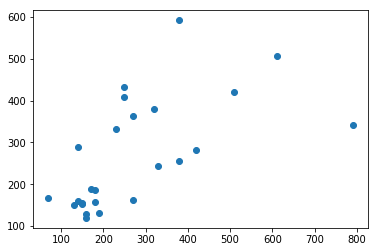

In [15]:
pred1 = np.array(RFR.oob_prediction_)
obs = np.array(y)
obs = [np.float(i) for i in obs]

print(pred1)
print(obs)
fig,ax = plt.subplots()
ax.scatter(obs,pred1)
plt.show()

In [16]:
print(RFR.feature_importances_)

[0.03076302 0.03309292 0.02191851 0.13730636 0.00691975 0.00954047
 0.01170407 0.06915878 0.16076827 0.00762218 0.00793526 0.0293753
 0.15360157 0.0169815  0.035099   0.0573158  0.04268409 0.14783471
 0.02037845]


In [17]:
# Predicting the rest of the image

# Take our full image and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (img.shape[0] * img.shape[1], img.shape[2])
img_as_array = img[:, :, :].reshape(new_shape)

print('Reshaped from {o} to {n}'.format(o=img.shape, n=img_as_array.shape))

img_as_array = np.nan_to_num(img_as_array)

Reshaped from (458, 83, 19) to (38014, 19)


In [18]:
prediction_ = RFR.predict(img_as_array)

In [19]:
prediction = prediction_.reshape(img[:, :, 0].shape)
print('Reshaped back to {}'.format(prediction.shape))

Reshaped back to (458, 83)


In [20]:
cols = img.shape[1]
rows = img.shape[0]

prediction.astype(np.float16)

driver = gdal.GetDriverByName("gtiff")
outdata = driver.Create(prediction_map, cols, rows, 1, gdal.GDT_UInt16)
outdata.SetGeoTransform(img_ds.GetGeoTransform())##sets same geotransform as input
outdata.SetProjection(img_ds.GetProjection())##sets same projection as input
outdata.GetRasterBand(1).WriteArray(prediction)
outdata.FlushCache() ##saves to disk!!
print('Image saved to: {}'.format(prediction_map))

Image saved to: D:\OwnCloud\WetScapes\2020_02_21_Regression_Biomass\Results\prediction_map.tif


In [ ]:
# 

In [26]:
img.shape

(458, 83, 19)

In [27]:
y

array([160, 150,  70, 180, 270, 380, 250, 320, 790, 270, 510, 230, 140,
       140, 180, 160, 150, 190, 130, 170, 330, 420, 380, 610, 250],
      dtype=uint16)

In [29]:
X.shape

(25, 19)

In [30]:
features = pd.DataFrame(X)

In [31]:
features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,129.0,113.0,80.0,4.806193,0.057959,0.071329,0.145246,0.186718,0.447160,181.0,170.0,130.0,4.678855,0.088964,0.101915,0.221553,0.261760,0.439525,0.127338
1,119.0,114.0,69.0,4.965296,0.054273,0.052538,0.145605,0.197211,0.579276,157.0,144.0,106.0,4.684095,0.106843,0.114630,0.236461,0.277434,0.415248,0.281201
2,136.0,118.0,83.0,4.754364,0.067470,0.079177,0.150295,0.184098,0.398524,199.0,199.0,161.0,4.567229,0.108079,0.130173,0.212995,0.240255,0.297173,0.189366
3,137.0,124.0,81.0,4.482555,0.060446,0.067874,0.163100,0.215910,0.521650,150.0,134.0,110.0,4.244701,0.080401,0.099191,0.165962,0.195841,0.327592,0.230469
4,141.0,139.0,88.0,3.828756,0.072505,0.065997,0.212558,0.272465,0.610018,183.0,173.0,139.0,3.538703,0.089225,0.101101,0.212972,0.253492,0.429764,0.290053


In [42]:
band_names = []
for i in range(X.shape[1]):
#for i in range(0,2500):
    nband = "Band_"+ str(i+1)
    band_names.append(nband)

band_names


['Band_1',
 'Band_2',
 'Band_3',
 'Band_4',
 'Band_5',
 'Band_6',
 'Band_7',
 'Band_8',
 'Band_9',
 'Band_10',
 'Band_11',
 'Band_12',
 'Band_13',
 'Band_14',
 'Band_15',
 'Band_16',
 'Band_17',
 'Band_18',
 'Band_19']

In [43]:
features.columns = band_names
features.head()

,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,Band_8,Band_9,Band_10,Band_11,Band_12,Band_13,Band_14,Band_15,Band_16,Band_17,Band_18,Band_19
0,129.0,113.0,80.0,4.806193,0.057959,0.071329,0.145246,0.186718,0.447160,181.0,170.0,130.0,4.678855,0.088964,0.101915,0.221553,0.261760,0.439525,0.127338
1,119.0,114.0,69.0,4.965296,0.054273,0.052538,0.145605,0.197211,0.579276,157.0,144.0,106.0,4.684095,0.106843,0.114630,0.236461,0.277434,0.415248,0.281201
2,136.0,118.0,83.0,4.754364,0.067470,0.079177,0.150295,0.184098,0.398524,199.0,199.0,161.0,4.567229,0.108079,0.130173,0.212995,0.240255,0.297173,0.189366
3,137.0,124.0,81.0,4.482555,0.060446,0.067874,0.163100,0.215910,0.521650,150.0,134.0,110.0,4.244701,0.080401,0.099191,0.165962,0.195841,0.327592,0.230469
4,141.0,139.0,88.0,3.828756,0.072505,0.065997,0.212558,0.272465,0.610018,183.0,173.0,139.0,3.538703,0.089225,0.101101,0.212972,0.253492,0.429764,0.290053


In [22]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split


In [23]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [24]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (18, 19)
Training Labels Shape: (18,)
Testing Features Shape: (7, 19)
Testing Labels Shape: (7,)


In [25]:
# Saving feature names for later use
feature_list = list(features.columns)


# The baseline predictions are the historical averages
baseline_preds = test_features[:, feature_list.index('average')]
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

NameError: name 'feature_list' is not defined